# Scores


#### Imports


In [1]:
from dataclasses import dataclass
from datetime import datetime

from IPython.display import display, HTML
import httpx
from authlib.integrations.httpx_client import OAuth2Auth
from kilroyplot.plot import plt
import pandas as pd

#### Configuration


In [2]:
client_id = "XXXXXXXXXXXXXXXXXXXXXX"
client_secret = "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX"
refresh_token = "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX"
user_agent = "kilroybot by u/kilroy-bot"
subreddit = "kilroybot"

In [4]:
start = datetime(2023, 1, 1, 0, 0, 0)
end = datetime(2023, 1, 31, 0, 0, 0)

#### Data


In [5]:
@dataclass
class Submission:
    id: int
    text: str
    created: datetime
    score: float

In [6]:
async def get_auth(client_id, client_secret, refresh_token, user_agent):
    url = "https://www.reddit.com/api/v1/access_token"
    headers = {"User-Agent": user_agent}
    payload = {
        "grant_type": "refresh_token",
        "refresh_token": refresh_token,
    }

    async with httpx.AsyncClient() as client:
        response = await client.post(
            url,
            headers=headers,
            data=payload,
            auth=(client_id, client_secret),
        )
        response.raise_for_status()

    token = {
        "token_type": response.json()["token_type"],
        "access_token": response.json()["access_token"],
    }
    auth = OAuth2Auth(token=token)
    return auth

In [7]:
async def get_client(client_id, client_secret, refresh_token, user_agent):
    auth = await get_auth(client_id, client_secret, refresh_token, user_agent)
    headers = {"User-Agent": user_agent}
    return httpx.AsyncClient(auth=auth, headers=headers)

In [8]:
async def get_subreddit_submissions(client, subreddit):
    url = f"https://oauth.reddit.com/r/{subreddit}/new"

    while True:
        response = await client.get(url)
        response.raise_for_status()

        data = response.json()
        for submission in data["data"]["children"]:
            yield submission["data"]

        after = data["data"].get("after", None)
        if after is None:
            break
        url = f"https://oauth.reddit.com/r/{subreddit}/new?after={after}"

In [9]:
async def get_all_my_posts(
    client_id, client_secret, refresh_token, user_agent, subreddit
):
    client = await get_client(
        client_id, client_secret, refresh_token, user_agent
    )
    async with client as client:
        async for submission in get_subreddit_submissions(client, subreddit):
            yield submission

In [10]:
def encode_submission(submission):
    return Submission(
        id=submission["id"],
        text=submission["title"],
        created=datetime.fromtimestamp(submission["created_utc"]),
        score=submission["score"],
    )

In [11]:
async def get_submissions(
    client_id, client_secret, refresh_token, user_agent, subreddit
):
    async for submission in get_all_my_posts(
        client_id, client_secret, refresh_token, user_agent, subreddit
    ):
        yield encode_submission(submission)

In [12]:
submissions = [
    submission
    async for submission in get_submissions(
        client_id, client_secret, refresh_token, user_agent, subreddit
    )
]

In [13]:
df = pd.DataFrame(
    submissions,
    columns=["text", "created", "score"],
    index=[submission.id for submission in submissions],
)

In [14]:
df = df[(df.created >= start) & (df.created <= end)]

#### Results


In [15]:
def plot_scores(df, x_label="Day", y_label="Score"):
    data = df.groupby(pd.Grouper(key="created", freq="1D"))["score"].mean()
    x = range(1, len(data) + 1)
    y = data.values
    plt.plot(x, y, marker="o", markersize=6, linestyle="--", dashes=(2, 2))
    plt.xlabel(x_label)
    plt.ylabel(y_label)

In [16]:
def print_top(df, n=30):
    top = df.sort_values("score", ascending=False)[["text", "score"]].head(n)
    display(HTML(top.to_html()))

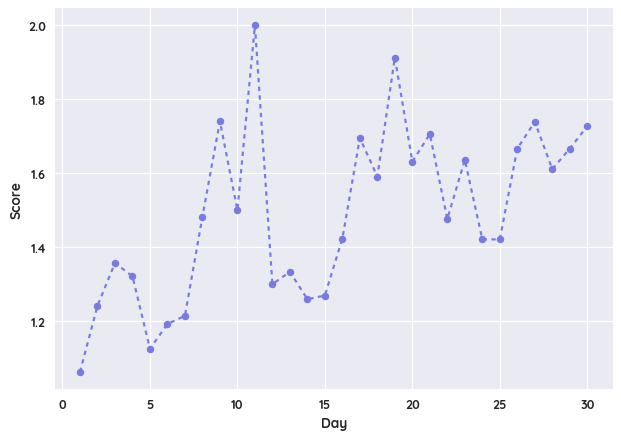

In [17]:
plot_scores(df)

In [22]:
print_top(df)

,text,score
10907jo,I don't know if I want to be loved (I'd rather be avoided than loved),6
108pia9,What's the point of living in the moment? Just wondering.,5
10gnzo4,"Once upon a time a backstory led to an inability to travel together at a time, giving the dilemma of choosing between International Spirit or Evil Spirit.",5
105k23i,There is no ham in hamburgers,5
10fx1oa,Counting up all these losses is a common mistake.,5
107599m,You can teleport anywhere and teleport languages anywhere.,4
10n7rqt,People no longer have nice things. They don't still have freedom of speech. They just don't know what other people will react to. You look at how,4
10gfd94,watching the videos from school is pointless since i'm just staring at a screen),4
10n8ryg,I feel stronger with just my honest thoughts now,4
10fvoid,People Shouldn't Be Having Sex At Night.,4
